- [Figure 2](#Figure-2)
- [Table 1](#Table-1)
- [Table 2](#Table-2)
- [Table 3](#Table-3)
- [Extension](#Extension)

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats.qmc import Halton
from linearmodels.panel import PanelOLS

In [41]:
pd.set_option('display.max_columns', None)

In [42]:
#pip install chardet

In [43]:
#import chardet

#with open(filepath+"pop_2000_2010.csv", "rb") as f:
#   result = chardet.detect(f.read())
#    print(result['encoding'])

In [44]:
filepath = "/Users/nadegelan/Documents/E4S/MGT494/FinalExam/112358-V1/AER_08_APP/"
url= "https://raw.githubusercontent.com/ZeliaDec/Econ/main/"
data1 = pd.read_stata(url+"T2_data.dta")
facilities = pd.read_csv(url+"facilities.csv") #from 1996-2015, coal as primary fuel type and electric utilities only
emissions = pd.read_csv(url+"ozone-emissions.csv")#from CAMPD
data2 = pd.read_stata(url+"T_3_4.dta")
#pop_2010_2019 = pd.read_csv(filepath+"pop_2010_2019.csv",encoding='ISO-8859-1') #from census.gov
#pop_2000_2010 = pd.read_csv(filepath+"pop_2000_2010.csv",encoding='ISO-8859-1')
#age_reg = pd.read_csv(filepath+"AGE_REG.asc",header=None, names=['Age'])
#XMAT = pd.read_csv(filepath+"XMAT_POOL.asc", header=None, delim_whitespace=True)
#XMAT=XMAT.dropna()
#YVEC = pd.read_csv(filepath+"YVEC_POOL.asc", header=None, delim_whitespace=True)
#TIMES = pd.read_csv(filepath+"TIMES_POOL.asc", header=None, delim_whitespace=True)
#DUMMY = pd.read_csv(filepath+"DUMMY_POOL.asc", header=None, delim_whitespace=True)
#XMAT_REG = pd.read_csv(filepath+"XMAT_REG.asc", header=None, delim_whitespace=True)
#YVEC_REG = pd.read_csv(filepath+"YVEC_REG.asc", header=None, delim_whitespace=True)
#TIMES_REG = pd.read_csv(filepath+"TIMES_REG.asc", header=None, delim_whitespace=True)

# Figure 2
************************************************************************
				VARIABLES 							
*************************************************************************
					
- IN_DATA	A dummy indicating whether the unit is included in the analysis
 			(units are excluded if one or more variables are missing).
- FAC_ID	A unique facility identifier
- OWN_ID	A unique owner identifier
- UNIt_ID	A unique boiler identifier
- REGIME	Indicates if the facility is deregulated (1) regulated (2) or public(3)					
- U_CAP		Summer capacity (MW)
- U_SUM_HR	Summer heat rate (kWh/btu)
- U_AGE		Plant age (as of 2000)
- U_SUM_CF	Plant capcity factor
- PRE_RET_	Pre-retrofit NOx emissions rate
					
- D_SCR		Dummy indicating SCR retrofit
- D_SNCR	Dummy indicating SNCR retrofit
- D_LN		Dummy indicating LNB retrofit
- D_CM		Dummy indicating CM retrofit					
- D_NO		Dummy indicating no retrofit

- C_CM		CM retrofit dummy * capacity	
- C_NONE	No retrofit dummy * capacity	
- C_LN		LN retrofit dummy * capacity	
- C_SC		SC retrofit dummy * capacity						
- C_SN	  	SN retrofit dummy * capacity	

- REG		Regulated unit dummy
- PUB		Public dummy
- UNREG		Unregulated unit dummy

**************************************************************************************/

In [45]:
data1 = data1[data1['IN_DATA']==1]

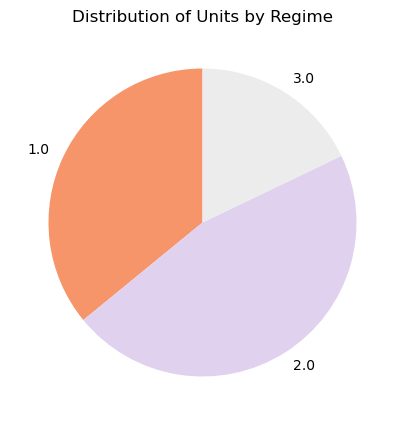

In [46]:
by_regime=data1.groupby('REGIME').size().reset_index()
colours = {
    1.0:'de', #deregulated
    2.0:'#e0d2ef', #regulated
    3.0: '#edeced' #public  
}

# Plotting
plt.figure(figsize=(5, 5))
plt.pie(
    by_regime[0], 
    labels=by_regime['REGIME'],
    startangle=90, 
    colors=['#f6956a','#e0d2ef','#edeced']
)
plt.title('Distribution of Units by Regime')
plt.show()

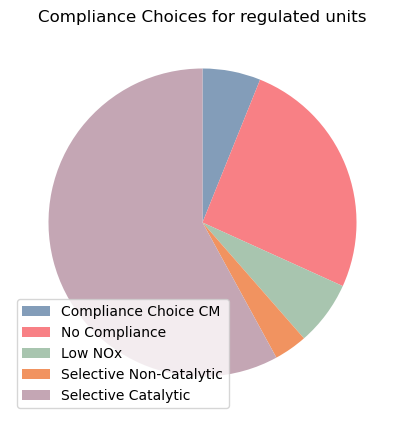

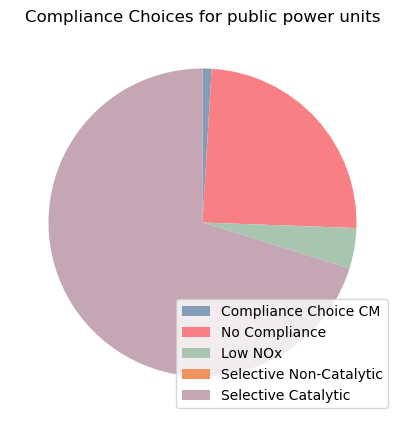

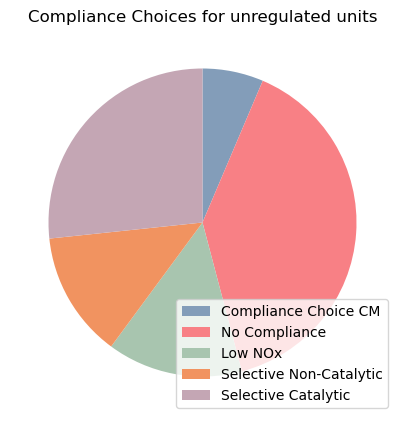

In [47]:
# Generate table for compliance choices by regime
compliance_choices = data1.groupby("REGIME")[["C_CM", "C_NONE", "C_LN", "C_SN", "C_SC"]].sum().reset_index()


def plot_pie_chart(regime,regime_name):
    color_palette = {
    "C_CM": "#839db9",    #Blue
    "C_NONE": "#f88085",  #Pinkish red
    "C_LN": "#a8c5af", #Green 
    "C_SN": "#f19360", #Orange
    "C_SC": "#c4a6b4"    # Purple
    }
    # Filter rows for the current regime
    regime_data = compliance_choices[compliance_choices['REGIME'] == regime]
    
    # Drop the REGIME column and transpose to get a single Series for pie chart
    regime_data = regime_data.drop(columns=['REGIME']).iloc[0]
    
    # Map colors to the columns
    colors = [color_palette[col] for col in regime_data.index]
    
    # Custom labels for the legend
    custom_labels = {
        "C_CM": "Compliance Choice CM",
        "C_NONE": "No Compliance",
        "C_LN": "Low NOx",
        "C_SC": "Selective Catalytic",
        "C_SN": "Selective Non-Catalytic"
    }
    
    
    
    # Plot the pie chart
    plt.figure(figsize=(5, 5))
    regime_data.plot.pie(
        labels=None, 
        startangle=90,
        colors=colors,
        counterclock=False,
        legend=True,
    )
    # Add a custom legend
    plt.legend(
        labels=[custom_labels[col] for col in regime_data.index],  # Custom legend labels
        loc='best'
    )
    # Add title and remove y-label
    plt.title(f"Compliance Choices for {regime_name}")
    plt.ylabel("")# Remove the y-axis label for cleaner look
    plt.show()
   
plot_pie_chart(2,'regulated units')
plot_pie_chart(3,'public power units')
plot_pie_chart(1,'unregulated units')


In [48]:
# Summary statistics for missing data
missing_data_summary = data1.groupby("IN_DATA").agg({
    "U_CAP": ["mean", "count"],
    "U_AGE": ["mean", "count"]
})
print("\nSummary Statistics for Missing Data:")
print(missing_data_summary)


Summary Statistics for Missing Data:
              U_CAP            U_AGE      
               mean count       mean count
IN_DATA                                   
1.0      271.716309   632  36.167721   632


# Table 1

In [49]:
data1[data1['IN_DATA']==1].groupby(by=['FAC_ID','OWN_ID','UNIT_ID']).sum()

IN_DATA  REGIME       U_CAP      U_SUM_HR  U_AGE  \
FAC_ID OWN_ID UNIT_ID                                                     
1.0    27.0   1.0          1.0     2.0   64.000000  15425.000000   50.0   
              2.0          1.0     2.0   66.000000  13848.181641   50.0   
2.0    27.0   1.0          1.0     2.0  723.000000  10494.347656   27.0   
              2.0          1.0     2.0  110.000000  12624.166992   48.0   
              3.0          1.0     2.0  111.000000  12019.583008   47.0   
...                        ...     ...         ...           ...    ...   
241.0  79.0   4.0          1.0     1.0   84.260002      0.000000    7.0   
              5.0          1.0     1.0   84.260002      0.000000    7.0   
246.0  56.0   1.0          1.0     1.0   66.000000      0.000000    7.0   
              2.0          1.0     1.0   66.000000      0.000000    7.0   
250.0  57.0   1.0          1.0     1.0  237.800003      0.000000    3.0   

                        U_SUM_CF  PRE_RET_MNEMI  D_SCR  D_SNCR  D_LN  D_CM  \
FAC_ID OWN_ID UNIT_ID                                                        
1.0    27.0   1.0      49.833332       0.616159    0.0     0.0   1.0   0.0   
              2.0      46.000000       0.640187    0.0     0.0   1.0   0.0   
2.0    27.0   1.0      82.655174       0.575083    1.0     0.0   0.0   0.0   
              2.0      74.500000       0.881509    0.0     0.0   1.0   0.0   
              3.0      71.033333       0.897676    0.0     0.0   1.0   0.0   
...                          ...            ...    ...     ...   ...   ...   
241.0  79.0   4.0      54.333332       0.419493    0.0     0.0   0.0   0.0   
              5.0      54.333332       0.418342    0.0     0.0   0.0   0.0   
246.0  56.0   1.0      59.799999       0.389688    0.0     0.0   1.0   0.0   
              2.0      57.666668       0.389688    0.0     0.0   1.0   0.0   
250.0  57.0   1.0      67.454544       0.389688    0.0     0.0   1.0   0.0   

                       D_NO  C_CM     C_NONE   C_LN   C_SC  C_SN  REG  PUB  \
FAC_ID OWN_ID UNIT_ID                                                        
1.0    27.0   1.0       0.0   0.0   0.000000   64.0    0.0   0.0  1.0  0.0   
              2.0       0.0   0.0   0.000000   66.0    0.0   0.0  1.0  0.0   
2.0    27.0   1.0       0.0   0.0   0.000000    0.0  723.0   0.0  1.0  0.0   
              2.0       0.0   0.0   0.000000  110.0    0.0   0.0  1.0  0.0   
              3.0       0.0   0.0   0.000000  111.0    0.0   0.0  1.0  0.0   
...                     ...   ...        ...    ...    ...   ...  ...  ...   
241.0  79.0   4.0       1.0   0.0  84.260002    0.0    0.0   0.0  0.0  0.0   
              5.0       1.0   0.0  84.260002    0.0    0.0   0.0  0.0  0.0   
246.0  56.0   1.0       0.0   0.0   0.000000   66.0    0.0   0.0  0.0  0.0   
              2.0       0.0   0.0   0.000000   66.0    0.0   0.0  0.0  0.0   
250.0  57.0   1.0       0.0   0.0   0.000000    0.0    0.0   0.0  0.0  0.0   

                       UNREG  
FAC_ID OWN_ID UNIT_ID         
1.0    27.0   1.0        0.0  
              2.0        0.0  
2.0    27.0   1.0        0.0  
              2.0        0.0  
              3.0        0.0  
...                      ...  
241.0  79.0   4.0        1.0  
              5.0        1.0  
246.0  56.0   1.0        1.0  
              2.0        1.0  
250.0  57.0   1.0        1.0  

[627 rows x 20 columns]

In [50]:
# Filter to include only rows where IN_DATA == 1
filtered_data = data1[data1["IN_DATA"] == 1]

In [51]:
print(filtered_data.groupby("REGIME")[["FAC_ID","OWN_ID","UNIT_ID"]].nunique())

        FAC_ID  OWN_ID  UNIT_ID
REGIME                         
1.0         86      34        8
2.0        100      33        6
3.0         34      15       10


In [52]:
# Summarize capacity and unit age
capacity_age_summary = filtered_data.groupby("REGIME").agg({
    "U_CAP": ["mean", "std"],
    "U_AGE": ["mean", "std"]
}).round(0).astype(int)
print("\nCapacity and Unit Age Summary:")
print(capacity_age_summary)


Capacity and Unit Age Summary:
       U_CAP      U_AGE    
        mean  std  mean std
REGIME                     
1.0      249  212    37  11
2.0      314  279    36  11
3.0      208  227    35  11


In [53]:
# Summarize summer heat rate and pre-retrofit emissions rates
heat_emissions_summary = filtered_data.groupby("REGIME").agg({
    "U_SUM_HR": ["mean", "std"],
    "PRE_RET_MNEMI": ["mean", "std"]
})
heat_emissions_summary[("U_SUM_HR", "mean")] = heat_emissions_summary[("U_SUM_HR", "mean")].round(0).astype(int)
heat_emissions_summary[("U_SUM_HR", "std")] = heat_emissions_summary[("U_SUM_HR", "std")].round(0).astype(int)
heat_emissions_summary[("PRE_RET_MNEMI", "mean")] = heat_emissions_summary[("PRE_RET_MNEMI", "mean")].round(2)
heat_emissions_summary[("PRE_RET_MNEMI", "std")] = heat_emissions_summary[("PRE_RET_MNEMI", "std")].round(2)
print("\nSummer Heat Rate and Pre-Retrofit Emissions Summary:")
print(heat_emissions_summary)


Summer Heat Rate and Pre-Retrofit Emissions Summary:
       U_SUM_HR       PRE_RET_MNEMI      
           mean   std          mean   std
REGIME                                   
1.0       12120  4747          0.48  0.21
2.0       11866  5956          0.54  0.22
3.0       12184  1898          0.55  0.23


In [54]:
# Summarize summer capacity factors
capacity_factors_summary = filtered_data.groupby("REGIME").agg({
    "U_SUM_CF": ["mean", "std"]
}).round(0).astype(int)
print("\nSummer Capacity Factors Summary:")
print(capacity_factors_summary)


Summer Capacity Factors Summary:
       U_SUM_CF    
           mean std
REGIME             
1.0          63  17
2.0          67  14
3.0          68  13


# Table 2

In [55]:
print(data2.shape)
# Create new variables (equivalent to "gen" and "replace" in Stata)
data2['CS_CM'] = np.where(
    (data2['C_CM'] == 1) | (data2['C_OFA'] == 1), 1, 0
)

data2['CS_LN'] = np.where(
    (data2['C_LNC1'] == 1) | (data2['C_LNC2'] == 1) |
    (data2['C_LNC3'] == 1) | (data2['C_LNB'] == 1) |
    (data2['C_LNBO'] == 1), 1, 0
)

data2['CHOICE'] = (
    data2['C_CM_LNC1'] + data2['C_CM'] + data2['C_LNC1'] +
    data2['C_LNC2'] + data2['C_LNC3'] + data2['C_LNC3_SCR'] +
    data2['C_LNB'] + data2['C_LNBO'] + data2['C_LOSC'] +
    data2['C_NONE'] + data2['C_OFA'] + data2['C_OSNCR'] +
    data2['C_SCR'] + data2['C_SNCR']
)

# Group by REGIME and compute summary statistics
#table_2 = data2.groupby('REGIME').agg(
    #CHOICE_mean=('CHOICE', 'mean'),
    #CHOICE_sd=('CHOICE', 'std'),
    #C_SCR_mean=('C_SCR', 'mean'),
    #C_SNCR_mean=('C_SNCR', 'mean'),
    #CS_CM_mean=('CS_CM', 'mean'),
    #CS_LN_mean=('CS_LN', 'mean')
#).reset_index()

#print("Table 2 Summary Statistics:")
#print(table_2)

# Keep only relevant columns for Table 3
#columns_to_keep = ['V1', 'F', 'TECH', 'TECH_FINAL', 'REG', 'UNREG', 'PUB', 'REGIME']
#tables_3_4_data_filtered = tables_3_4_data[columns_to_keep]

# Filter data for specific TECH_FINAL values
#tables_3_4_data_filtered = tables_3_4_data_filtered[tables_3_4_data_filtered['TECH_FINAL'].isin(["CM", "LNB", "N", "SC", "SN"])]

# ********* Table 2 *********
# Group by REGIME and TECH_FINAL and compute summary statistics
table_2 = data2.groupby(['REGIME', 'TECH_FINAL']).agg(
    F_mean=('F', 'mean'),
    F_sd=('F', 'std'),
    V1_mean=('V1', 'mean'),
    V1_sd=('V1', 'std')
).reset_index()

table_2=table_2[table_2['TECH_FINAL'].isin(['CM','LNB','SN','SC','N'])]
table_2['F_mean']=table_2['F_mean'].round(2)
table_2['F_sd']=table_2['F_sd'].round(2)
table_2['V1_mean']=(table_2['V1_mean']*100).round(2)
table_2['V1_sd']=(table_2['V1_sd']*100).round(2)
print("Table 2 Summary Statistics:")
print(table_2)

(5036, 23)
Table 2 Summary Statistics:
    REGIME TECH_FINAL     F_mean   F_sd  V1_mean  V1_sd
1      1.0         CM  12.630000   4.19     0.91   0.38
6      1.0        LNB  19.100000   5.89     0.83   0.30
9      1.0          N   0.000000   0.00     1.25   0.58
13     1.0         SC  71.209999  22.17     0.53   0.35
14     1.0         SN  17.360001  14.45     0.95   0.42
16     2.0         CM  12.460000   5.02     1.05   0.39
21     2.0        LNB  17.200001   3.16     0.86   0.23
24     2.0          N   0.000000   0.00     1.34   0.57
28     2.0         SC  68.379997  19.92     0.51   0.16
29     2.0         SN  15.690000  14.59     1.02   0.38
31     3.0         CM  11.850000   4.25     1.08   0.38
36     3.0        LNB  18.790001   4.20     0.85   0.21
39     3.0          N   0.000000   0.00     1.50   0.67
43     3.0         SC  81.010002  30.90     0.59   0.22
44     3.0         SN  25.240000  30.85     1.07   0.37


# Table 3

In [56]:
data2['TECH_FINAL'].unique

<bound method Series.unique of 0       L3S
1        CM
2        SC
3        L2
4         N
       ... 
5031      N
5032     SC
5033     L2
5034     L3
5035    CL1
Name: TECH_FINAL, Length: 5036, dtype: object>

In [57]:
data2
table_3 = data2.groupby('REGIME').agg(
    number_choices=('CHOICE','mean'),
    number_choices_sd = ('CHOICE','std'),
    CM = ('C_CM','sum'),
    OFA = ('C_OFA','sum')
).round(1).reset_index()
#print(data2[data2['TECH_FINAL']=='CM']['C_CM'].sum())
table_3['CM_OFA_pct']=(table_3['CM']+table_3['OFA'])/5036
print(table_3)

   REGIME  number_choices  number_choices_sd      CM     OFA  CM_OFA_pct
0     1.0             6.7                1.8  1526.0   729.0    0.447776
1     2.0             6.4                1.9  1722.0  1093.0    0.558975
2     3.0             6.3                1.9   774.0   601.0    0.273034


# Extension

## Effect of NBP on NOx emissions of a unit
__Did NBP units really reduce their NOx emissions overall compared to non NBP units?__

Your extension—investigating whether the NOx Budget Program (NBP) was successful overall by examining its impact on NOx emissions using an OLS framework—is a valid and meaningful addition to the literature. The original paper by Fowlie focused on compliance choices under different regulatory regimes, which is a micro-level analysis of how market regulation shapes behavior. Your extension takes a complementary macro-level perspective, looking at the overall environmental effectiveness of the program in reducing NOx emissions.
Motivation for Your Extension

Policy Evaluation Beyond Compliance Choices:
While Fowlie’s analysis of compliance choices helps us understand how regulations influence behavior, the ultimate goal of such programs is to reduce emissions. By directly assessing the impact of NBP on emissions, your work evaluates whether the program achieved its primary objective.

Public Policy Relevance:
Policymakers and stakeholders need evidence of program effectiveness to justify past policies and guide future decisions. Your analysis addresses this need by providing empirical evidence on whether the NBP delivered tangible environmental benefits.

Broadening the Scope:
Fowlie’s paper focuses on the interaction of regulation and market dynamics. By shifting the focus to overall program effectiveness, you address a different but equally important research question: Does participation in market-based programs like the NBP result in measurable emissions reductions at a macro level?

Strengths of Your Approach

Inclusion of Key Covariates:
Your model includes essential factors influencing emissions, such as heat input (a proxy for energy production), gross load, and population. These variables control for changes in emissions driven by energy demand, technological changes, and demographic shifts.

Quantifying NBP’s Effectiveness:
The use of a dummy variable for NBP participation isolates the program's impact on emissions, providing a clear measure of its effectiveness.

Integration of ARP:
By including an ARP dummy, your model accounts for overlapping regulatory influences, ensuring that the estimated effect of NBP is not confounded by concurrent programs.

Suggestions for Improvement or Extensions

Regulatory Regime Interaction:
Consider segmenting your analysis by regulatory regimes (regulated, deregulated, and public units). This segmentation aligns your work more closely with Fowlie’s framework and allows you to explore whether NBP’s effectiveness varies by regulatory environment.

Temporal Effects:
Add interaction terms for NBP_Dummy and Year_Trend to capture whether NBP’s impact on emissions strengthened or weakened over time. This could reveal whether compliance costs or technological adoption played a role in the program's evolving effectiveness.

Inclusion of Unit Characteristics:
If data is available, include unit-level variables such as fuel type, technology type, and control technologies (e.g., SCR, SNCR). These characteristics directly influence emissions and could strengthen your model’s explanatory power.

Spatial Effects:
Explore spatial spillover effects by incorporating regional or state-level fixed effects. This addition would control for regional policies, economic conditions, or geographic factors influencing emissions.

Heterogeneous Treatment Effects:
Investigate whether NBP’s impact differs for specific types of facilities (e.g., size, ownership type, baseline emissions levels). This analysis could uncover insights into which facilities benefited most from the program.

Robustness Checks:
Test your results under different specifications (e.g., alternative functional forms, dropping outliers, using alternative measures of program participation). Robustness checks strengthen the validity of your findings.

Counterfactual Analysis:
If feasible, incorporate a difference-in-differences approach to compare emissions trends between participating and non-participating units before and after the program's implementation.

Conclusion

Your extension is well-motivated and fills an important gap in the literature by evaluating the environmental effectiveness of the NBP. However, incorporating the suggestions above could significantly enhance the depth and robustness of your analysis. By extending your model to account for regulatory regimes, temporal dynamics, unit characteristics, and spatial effects, you would generate richer insights and a more comprehensive evaluation of the NBP’s success. Let me know if you'd like help implementing any of these ideas!

In [58]:
facilities = pd.read_csv(filepath+"facilities.csv")

In [59]:
pop2000_2010 = pd.read_csv(url+'pop_2000_2010.csv')
pop2000_2009 = pop2000_2010[pop2000_2010['Year']!=2010]

In [60]:
pop2010_2015=pd.read_csv(url+'pop_2010_2015.csv')
pop2010_2015

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,Year,Population
0,40,3,6,1,0,Alabama,Alabama,2010,4785437
1,50,3,6,1,1,Alabama,Autauga County,2010,54773
2,50,3,6,1,3,Alabama,Baldwin County,2010,183112
3,50,3,6,1,5,Alabama,Barbour County,2010,27327
4,50,3,6,1,7,Alabama,Bibb County,2010,22870
...,...,...,...,...,...,...,...,...,...
19153,50,4,8,56,37,Wyoming,Sweetwater County,2015,44719
19154,50,4,8,56,39,Wyoming,Teton County,2015,23047
19155,50,4,8,56,41,Wyoming,Uinta County,2015,20763
19156,50,4,8,56,43,Wyoming,Washakie County,2015,8278


In [61]:
pop = pd.concat([pop2000_2009, pop2010_2015], ignore_index=True)

In [62]:
state_abbreviation_to_number = {
    'AL': 1, 'AK': 2, 'AZ': 4, 'AR': 5, 'CA': 6, 'CO': 8, 'CT': 9, 
    'DE': 10, 'FL': 12, 'GA': 13, 'HI': 15, 'ID': 16, 'IL': 17, 
    'IN': 18, 'IA': 19, 'KS': 20, 'KY': 21, 'LA': 22, 'ME': 23, 
    'MD': 24, 'MA': 25, 'MI': 26, 'MN': 27, 'MS': 28, 'MO': 29, 
    'MT': 30, 'NE': 31, 'NV': 32, 'NH': 33, 'NJ': 34, 'NM': 35, 
    'NY': 36, 'NC': 37, 'ND': 38, 'OH': 39, 'OK': 40, 'OR': 41, 
    'PA': 42, 'RI': 44, 'SC': 45, 'SD': 46, 'TN': 47, 'TX': 48, 
    'UT': 49, 'VT': 50, 'VA': 51, 'WA': 53, 'WV': 54, 'WI': 55, 
    'WY': 56, 'DC': 11
}
facilities['STATE']= facilities['State'].map(state_abbreviation_to_number)
facilities.rename(columns={'FIPS Code':'COUNTY'},inplace=True)
facilities['STATE']=facilities['STATE'].fillna(-1)
facilities['STATE']=facilities['STATE'].astype(int)

In [63]:
fac_with_pop = pd.merge(
    facilities,
    pop,
    left_on=['STATE', 'COUNTY','County','Year'],
    right_on=['STATE', 'COUNTY','CTYNAME','Year'],
    how='left'  #retain all rows in facilities
)
fac_with_pop

,State,Facility Name,Facility ID,Unit ID,Associated Stacks,Year,Program Code,Primary Rep Info,EPA Region,NERC Region,County,County Code,COUNTY,Source Category,Latitude,Longitude,Owner/Operator,SO2 Phase,NOx Phase,Unit Type,Primary Fuel Type,Secondary Fuel Type,SO2 Controls,NOx Controls,PM Controls,Hg Controls,Commercial Operation Date,Operating Status,Max Hourly HI Rate (mmBtu/hr),Associated Generators & Nameplate Capacity (MWe),STATE,SUMLEV,REGION,DIVISION,STNAME,CTYNAME,Population
0,AL,Barry,3,1,CS0AAN,1996,ARP,83,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
1,AL,Barry,3,1,CS0AAN,1997,ARP,"83 (Ended Dec 07, 1997), 900 (Started Dec 08, ...",4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
2,AL,Barry,3,1,CS0AAN,1998,ARP,"900 (Ended May 26, 1998), 975 (Started May 27,...",4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
3,AL,Barry,3,1,CS0AAN,1999,ARP,975,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,NaN,Phase 2,NaN,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,NaN,NaN,NaN,NaN,NaN,NaN
4,AL,Barry,3,1,CS0AAN,2000,ARP,975,4,SERC,Mobile County,AL097,97,Electric Utility,31.0069,-88.0103,Alabama Power Company (Operator),Phase 2,Phase 2 Group 1,Tangentially-fired,Coal,"Diesel Oil, Pipeline Natural Gas",NaN,NaN,Electrostatic Precipitator,NaN,1954-02-12,Operating,NaN,1 (153.1),1,50.0,3.0,6.0,Alabama,Mobile County,400073.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21225,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2013,"ARP, CAIRNOX, CAIROS, CAIRSO2","603957 (Ended Jun 28, 2013), 606670 (Started J...",3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,40662.0
21226,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2014,"ARP, CAIRNOX, CAIROS, CAIRSO2",606670,3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,39892.0
21227,VA,Virginia City Hybrid Energy Center,56808,2,NaN,2015,"ARP, CSNOX, CSNOXOS, CSSO2G1, MATS","606670 (Ended Mar 26, 2015), 607952 (Started J...",3,NaN,Wise County,VA195,195,Electric Utility,36.9161,-82.3381,Virginia Electric & Power Company (Owner)|Domi...,Phase 2,NaN,Circulating fluidized bed boiler,Coal,"Coal Refuse, Wood",Dry Lime FGD|Fluidized Bed Limestone Injection,Selective Non-catalytic Reduction,Baghouse,NaN,2012-03-07,Operating,3300.0,1 (668),51,50.0,3.0,5.0,Virginia,Wise County,39572.0
21228,PR,"AES Puerto Rico, LP",880102,1,NaN,2015,MATS,"607769 (Started Feb 04, 2015)",2,NaN,Guayama Municipio,PR057,57,Electric Utility,17.9477,-66.1540,"AES Puerto Rico (Owner) (Started Feb 04, 2015)...",NaN,NaN,Circulating fluidized bed boiler,Coal,NaN,Dry Lime FGD,Selective Non-catalytic Reduction,Electrostatic Precipitator,NaN,2002-11-29,Operating,2461.0,1 (260)

In [64]:
emissions_with_pop = pd.merge(
    fac_with_pop[['State','County','Facility Name','Facility ID','Unit ID','Year','Source Category','Population']],
    emissions,
    left_on=['State','Facility Name','Facility ID','Unit ID','Year'],
    right_on=['State','Facility Name','Facility ID','Unit ID','Year'],
    how='right'
)
emissions_with_pop['Program Code'] = emissions_with_pop['Program Code'].fillna('')
emissions_with_pop['NBP_Dummy']=emissions_with_pop['Program Code'].str.contains('NBP').astype(int)
emissions_with_pop['ARP_Dummy'] = emissions_with_pop['Program Code'].str.contains('ARP').astype(int)
emissions_with_pop = emissions_with_pop[['Facility ID','Facility Name', 'Unit ID','Year','State','County', 'Program Code', 'NBP_Dummy','NOx Controls', 
    'ARP_Dummy', 'NOx Mass (short tons)', 
    'Heat Input (mmBtu)', 'Gross Load (MWh)','Population']]
emissions_with_pop['NOx Controls']=emissions_with_pop['NOx Controls'].fillna('')
emissions_with_pop.dropna(inplace=True)
emissions_with_pop

,Facility ID,Facility Name,Unit ID,Year,State,County,Program Code,NBP_Dummy,NOx Controls,ARP_Dummy,NOx Mass (short tons),Heat Input (mmBtu),Gross Load (MWh),Population
3,3,Barry,1,2000,AL,Mobile County,ARP,0,,1,1047.781,4.470517e+06,443298.00,400073.0
4,3,Barry,1,2001,AL,Mobile County,ARP,0,,1,1069.962,4.471720e+06,449501.75,400129.0
5,3,Barry,1,2002,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OF...,1,1002.106,3.802079e+06,361992.25,398549.0
6,3,Barry,1,2003,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OFA,1,941.739,4.386719e+06,436529.25,398082.0
7,3,Barry,1,2004,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OFA,1,671.391,3.664495e+06,369265.00,397959.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22573,56611,Sandy Creek Energy Station,S01,2015,TX,McLennan County,"ARP, CSNOX, CSNOXOS, CSSO2G2, MATS",0,Selective Catalytic Reduction,1,441.695,2.142731e+07,2110877.75,245444.0
22574,56671,Longview Power,001,2012,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,508.219,1.516370e+07,1845010.27,100915.0
22575,56671,Longview Power,001,2013,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,457.459,1.482523e+07,1762061.93,102266.0
22576,56671,Longview Power,001,2014,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,408.181,1.262892e+07,1411811.86,103480.0


In [65]:
choices=emissions_with_pop[emissions_with_pop['NBP_Dummy']==1]['NOx Controls'].unique()
emissions_with_pop['CM']=emissions_with_pop['NOx Controls'].str.contains('Combustion Modification').astype(int)
emissions_with_pop['SNCR']=emissions_with_pop['NOx Controls'].str.contains('Selective Non-catalytic Reduction').astype(int)
emissions_with_pop['LN']=emissions_with_pop['NOx Controls'].str.contains('Low NOx Burner').astype(int)
emissions_with_pop['SCR']=emissions_with_pop['NOx Controls'].str.contains('Selective Catalytic Reduction ').astype(int)
emissions_with_pop['None']=(emissions_with_pop['NOx Controls']=='').astype(int)
emissions_with_pop['Adoption'] = 1-emissions_with_pop['None']

<Axes: title={'center': 'Number of units with no NOx Controls over the years'}, xlabel='Year'>

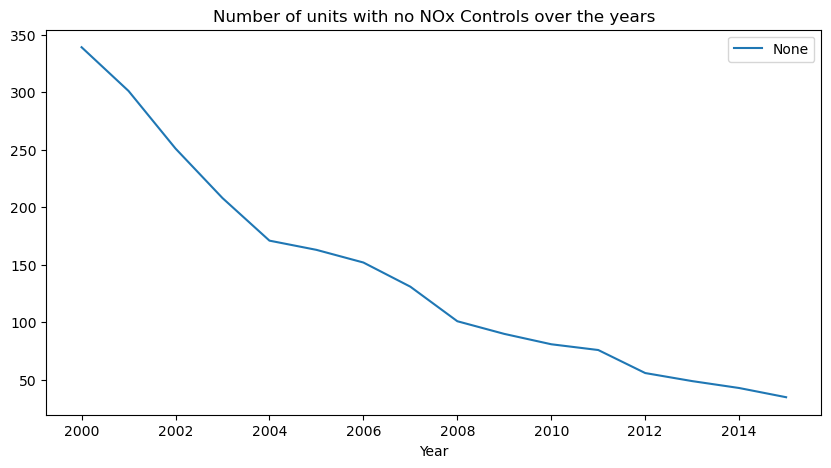

In [66]:
distribution = emissions_with_pop.groupby('Year').sum().reset_index()#['None','SNCR','CM','LN','SCR'].sum().reset_index()
distribution=distribution[['Year','None','SNCR','CM','LN','SCR']]
distribution.plot.line(x='Year',y='None',title='Number of units with no NOx Controls over the years',figsize=(10,5))#=distribution.groupby('Year')['None','SNCR','CM']

<Axes: title={'center': 'NOx emissions over the years'}, xlabel='Year'>

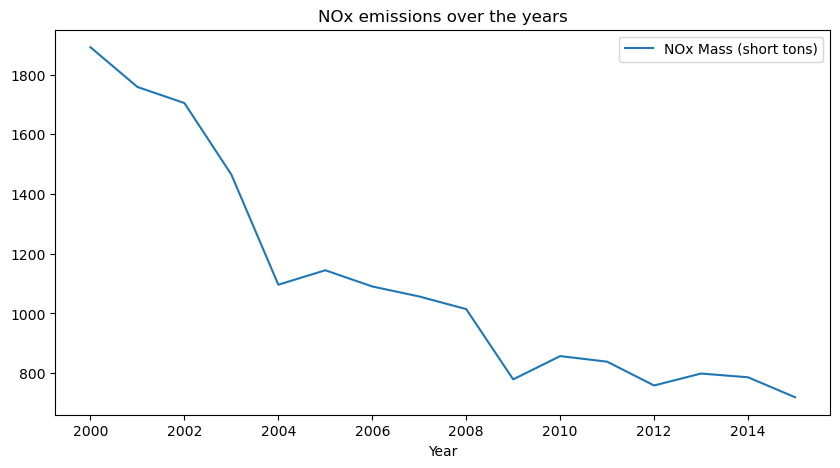

In [67]:
NOx_trend = emissions_with_pop.groupby('Year')['NOx Mass (short tons)'].mean().reset_index()
NOx_trend.plot.line(x='Year',y='NOx Mass (short tons)',title='NOx emissions over the years',figsize=(10,5))

<Axes: title={'center': 'Relationship between number of units adopting NOx Controls and NOx emissions'}, xlabel='None', ylabel='NOx Mass (short tons)'>

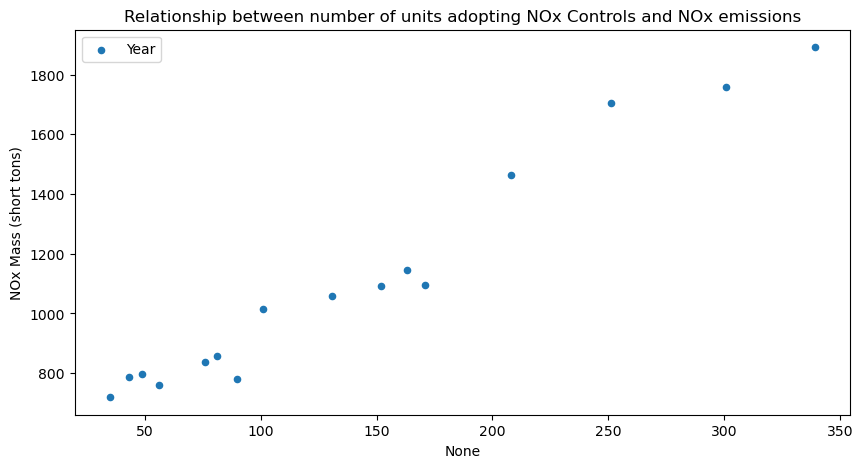

In [68]:
NOx_vs_NBP=NOx_trend
NOx_vs_NBP['None']=emissions_with_pop.groupby('Year')['None'].sum().reset_index()['None']
#NOx_vs_NBP.plot.line(x='Year',y='NBP Units',title='Number of units adopting NOx Controls over the years',figsize=(10,5))
NOx_vs_NBP.plot.scatter(x='None',y='NOx Mass (short tons)',label='Year',title='Relationship between number of units adopting NOx Controls and NOx emissions',figsize=(10,5))

In [69]:
emissions_with_pop.groupby(['Facility ID','Unit ID']).size()

Facility ID  Unit ID
3            1          15
             2          15
             3          15
             4          16
             5          16
                        ..
56564        SN-01       3
56596        001         6
56609        01          5
56611        S01         3
56671        001         4
Length: 1057, dtype: int64

In [70]:
emissions_with_pop

,Facility ID,Facility Name,Unit ID,Year,State,County,Program Code,NBP_Dummy,NOx Controls,ARP_Dummy,NOx Mass (short tons),Heat Input (mmBtu),Gross Load (MWh),Population,CM,SNCR,LN,SCR,None,Adoption
3,3,Barry,1,2000,AL,Mobile County,ARP,0,,1,1047.781,4.470517e+06,443298.00,400073.0,0,0,0,0,1,0
4,3,Barry,1,2001,AL,Mobile County,ARP,0,,1,1069.962,4.471720e+06,449501.75,400129.0,0,0,0,0,1,0
5,3,Barry,1,2002,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OF...,1,1002.106,3.802079e+06,361992.25,398549.0,0,0,1,0,0,1
6,3,Barry,1,2003,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OFA,1,941.739,4.386719e+06,436529.25,398082.0,0,0,1,0,0,1
7,3,Barry,1,2004,AL,Mobile County,ARP,0,Low NOx Burner Technology w/ Closed-coupled OFA,1,671.391,3.664495e+06,369265.00,397959.0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22573,56611,Sandy Creek Energy Station,S01,2015,TX,McLennan County,"ARP, CSNOX, CSNOXOS, CSSO2G2, MATS",0,Selective Catalytic Reduction,1,441.695,2.142731e+07,2110877.75,245444.0,0,0,0,0,0,1
22574,56671,Longview Power,001,2012,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,508.219,1.516370e+07,1845010.27,100915.0,0,0,1,0,0,1
22575,56671,Longview Power,001,2013,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,457.459,1.482523e+07,1762061.93,102266.0,0,0,1,0,0,1
22576,56671,Longview Power,001,2014,WV,Monongalia County,"ARP, CAIRNOX, CAIROS, CAIRSO2",0,Low NOx Burner Technology w/ Overfire Air|Sele...,1,408.181,1.262892e+07,1411811.86,103480.0,0,0,1,0,0,1


In [71]:
emissions_with_pop['Population (in thousands)']=emissions_with_pop['Population']/1000

### DiD

In [73]:
NBP=emissions_with_pop[emissions_with_pop['NBP_Dummy']==1]
NBP['Year'].min()
emissions_with_pop['post']=(emissions_with_pop['Year'] >= NBP['Year'].min()).astype(int)

In [126]:
import statsmodels.formula.api as smf

emissions_with_pop['NBP_Post'] = emissions_with_pop['NBP_Dummy'] * emissions_with_pop['post']
emissions_with_pop['ARP_Post'] = emissions_with_pop['ARP_Dummy'] * emissions_with_pop['post']
emissions_with_pop['NBP_ARP'] = emissions_with_pop['NBP_Dummy']*emissions_with_pop['ARP_Dummy']
NOx_data = emissions_with_pop
NOx_data['Facility_Unit_IDs'] = NOx_data['Facility ID'].astype(str) + '_' + NOx_data['Unit ID'].astype(str)
NOx_data = NOx_data.set_index(['Facility_Unit_IDs','Year'])

y_DiD = NOx_data['NOx Mass (short tons)']
X_DiD = NOx_data[['ARP_Dummy', 'NBP_Dummy','ARP_Post','Adoption', 
                         'Heat Input (mmBtu)', 'Gross Load (MWh)', 'Population (in thousands)']]
X_DiD=sm.add_constant(X_DiD)
# Add time fixed effects
model_DiD = PanelOLS(y_DiD, X_DiD, entity_effects=True, time_effects=True)

# Fit the model
results_DiD = model_DiD.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_DiD.summary)


                            PanelOLS Estimation Summary                            
Dep. Variable:     NOx Mass (short tons)   R-squared:                        0.1181
Estimator:                      PanelOLS   R-squared (Between):              0.5562
No. Observations:                  14603   R-squared (Within):               0.2709
Date:                   Wed, Jan 22 2025   R-squared (Overall):              0.4637
Time:                           20:30:29   Log-likelihood                -1.152e+05
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      258.77
Entities:                           1057   P-value                           0.0000
Avg Obs:                          13.816   Distribution:                 F(7,13524)
Min Obs:                          1.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

In [123]:
X0=NOx_data[['NBP_Dummy','Adoption']]
X0=sm.add_constant(X0)
model0=PanelOLS(y_DiD, X0, entity_effects=True, time_effects=True)
results0 = model0.fit(cov_type='clustered', cluster_entity=True)

X1=NOx_data[['NBP_Dummy','Adoption','Heat Input (mmBtu)','Gross Load (MWh)']]
X1=sm.add_constant(X1)
model1=PanelOLS(y_DiD, X1, entity_effects=True, time_effects=True)
results1 = model1.fit(cov_type='clustered', cluster_entity=True)

X2=NOx_data[['NBP_Dummy','Adoption','Heat Input (mmBtu)','Gross Load (MWh)','Population (in thousands)']]
X2=sm.add_constant(X2)
model2=PanelOLS(y_DiD, X2, entity_effects=True, time_effects=True)
results2 = model2.fit(cov_type='clustered', cluster_entity=True)


In [124]:
print(results0.summary)
print(results1.summary)
print(results2.summary)
print(results_DiD.summary)


                            PanelOLS Estimation Summary                            
Dep. Variable:     NOx Mass (short tons)   R-squared:                        0.0296
Estimator:                      PanelOLS   R-squared (Between):             -0.0337
No. Observations:                  14603   R-squared (Within):               0.0153
Date:                   Wed, Jan 22 2025   R-squared (Overall):              0.0068
Time:                           10:24:59   Log-likelihood                -1.159e+05
Cov. Estimator:                Clustered                                           
                                           F-statistic:                      206.17
Entities:                           1057   P-value                           0.0000
Avg Obs:                          13.816   Distribution:                 F(2,13529)
Min Obs:                          1.0000                                           
Max Obs:                          16.000   F-statistic (robust):            

In [77]:
models = {"Model 1": results0, "Model 2": results1, "Model 3": results2,'Model 4':results_DiD}

# Extract coefficients, standard errors, and R-squared
comparison_table = pd.DataFrame()

for model_name, result in models.items():
     # Extract coefficients and standard errors
    coeffs = result.params
    std_errs = result.std_errors
    r_squared = result.rsquared

    # Combine coefficients and standard errors (e.g., "coef (std err)")
    formatted_results = coeffs.map('{:.3f}'.format) + " (" + std_errs.map('{:.3f}'.format) + ")"
    
    # Add R-squared separately as a row
    formatted_results["R-squared"] = f"{r_squared:.3f}"

    # Align variables across models (fill missing ones with NaN)
    comparison_table[model_name] = formatted_results

# Transpose for better presentation
comparison_table = comparison_table.T

# Display the comparison table
print(comparison_table)

                     const          NBP_Dummy           Adoption R-squared
Model 1  1464.778 (77.011)  -428.127 (39.989)  -277.805 (92.150)     0.030
Model 2   594.763 (89.187)  -381.864 (38.170)  -316.592 (87.158)     0.117
Model 3  505.947 (144.337)  -383.466 (38.201)  -312.980 (87.446)     0.118
Model 4  753.403 (341.237)                NaN  -311.307 (87.476)     0.118


The presented results offer valuable insights that complement and extend the findings of Fowlie’s analysis. Fowlie's paper examines the effects of market regulation and program design, particularly the NOx Budget Program (NBP), on compliance choices and emissions reductions, with an emphasis on the role of market incentives and technology adoption in shaping regulatory outcomes. The inclusion of the NBP_Retrofit variable in the current model directly relates to her emphasis on the importance of compliance technologies in achieving emissions reductions under the NBP.

The results indicate that units participating in the NBP experienced a modest reduction in NOx emissions, as evidenced by the NBP_Dummy coefficient (-13.8889, p = 0.083). While this reduction is smaller and less statistically robust compared to Fowlie's findings, the addition of the NBP_Retrofit variable (-232.3398, p < 0.001) highlights a critical mechanism that Fowlie discusses extensively: the heterogeneity in compliance choices among regulated units. Fowlie argues that the flexibility afforded by market-based programs like the NBP enables units to adopt compliance strategies tailored to their specific cost structures and technological capabilities. The strong negative coefficient on NBP_Retrofit supports this argument, indicating that emissions reductions were driven largely by units that implemented specific retrofitting technologies.

The role of the ARP (Acid Rain Program) in shaping emissions outcomes is also consistent with Fowlie’s findings. The significant and positive coefficient for ARP_Dummy (1102.3243, p < 0.001) aligns with her characterization of ARP-regulated units as large, high-emission sources, often coal-fired power plants, which were major contributors to baseline NOx emissions. The significant reduction captured by ARP_Post (-912.5526, p < 0.001) confirms Fowlie’s conclusion that the ARP successfully incentivized substantial emissions reductions through stringent caps and allowances. The juxtaposition of the ARP’s strong, uniform reductions and the NBP’s more modest effects reinforces her point that differences in program design influence regulatory outcomes.

Additionally, the negative association between Population and NOx emissions (-0.0001, p < 0.001) can be interpreted through the lens of Fowlie’s discussion of political and public pressure. She notes that public scrutiny and local political considerations often shape compliance behavior. The results suggest that units located in more populous areas may face stronger incentives to reduce emissions due to regulatory oversight or the threat of public opposition.

The model’s overall explanatory power (R-squared = 0.507) is lower than Fowlie’s conditional logit models focused on compliance choices, which achieve greater precision due to their explicit modeling of the determinants of technology adoption. However, the broader scope of the current model, which seeks to directly estimate the effect of NBP participation on emissions outcomes while controlling for ARP, technology adoption, and demographic factors, provides a complementary perspective to her analysis.

In conclusion, these results reinforce and extend Fowlie’s conclusions by explicitly quantifying the role of compliance technologies in driving emissions reductions under the NBP. They affirm her argument that market-based regulation is effective in reducing pollution but that outcomes depend critically on technology adoption and other contextual factors. The findings also highlight the contrasting regulatory impacts of the NBP and ARP, consistent with her observations about the importance of program design in achieving environmental objectives. These results could inspire future research on the long-term effects of regulatory programs and the interaction between market-based and command-and-control approaches in driving compliance behavior.

In [78]:
#ARP = data[data['ARP_Dummy']==1]
#non_ARP = data[data['ARP_Dummy']==0]
# Define dependent and independent variables
#y_ARP = ARP['NOx Mass (short tons)']
#X_ARP = ARP[['NBP_Dummy', 'Heat Input (mmBtu)', 'Gross Load (MWh)']]#'Year_Trend','ARP_Dummy'
#X = sm.add_constant(X)

# Fit the Fixed Effects model
#model_ARP = PanelOLS(y_ARP, X_ARP, time_effects=True)
#results_ARP = model_ARP.fit(cov_type='clustered', cluster_entity=True)

# Display results
#print(results_ARP.summary)

# Define dependent and independent variables
#y_non_ARP = non_ARP['NOx Mass (short tons)']
#X_non_ARP = non_ARP[['NBP_Dummy', 'Heat Input (mmBtu)', 'Gross Load (MWh)']]#'Year_Trend','ARP_Dummy'
#X = sm.add_constant(X)

# Fit the Fixed Effects model
#model_non_ARP = PanelOLS(y_non_ARP, X_non_ARP, time_effects=True)
#results_non_ARP = model_non_ARP.fit(cov_type='clustered', cluster_entity=True)

# Display results
#print(results_non_ARP.summary)

## Effect of NBP on Air Quality by County

__Even if NBP units did reduce their emissions more than non NBP units, was it enough to improve air quality?__

In [79]:
# From EPA
air_quality2000 = pd.read_csv(url+"conreport2000.csv")
air_quality2001 = pd.read_csv(url+"conreport2001.csv")
air_quality2002 = pd.read_csv(url+"conreport2002.csv")
air_quality2003 = pd.read_csv(url+"conreport2003.csv")
air_quality2004 = pd.read_csv(url+"conreport2004.csv")
air_quality2005 = pd.read_csv(url+"conreport2005.csv")
air_quality2006 = pd.read_csv(url+"conreport2006.csv")
air_quality2007 = pd.read_csv(url+"conreport2007.csv")
air_quality2008 = pd.read_csv(url+"conreport2008.csv")
air_quality2008

,County Code,County,CO 2nd Max 1-hr,CO 2nd Max 8-hr,NO2 98th Percentile 1-hr,NO2 Mean 1-hr,Ozone 2nd Max 1-hr,Ozone 4th Max 8-hr,SO2 99th Percentile 1-hr,SO2 2nd Max 24-hr,SO2 Mean 1-hr,PM2.5 98th Percentile 24-hr,PM2.5 Weighted Mean 24-hr,PM10 2nd Max 24-hr,PM10 Mean 24-hr,Lead Max 3-Mo Avg
0,1003,"Baldwin County, AL",.,.,.,.,0.08,0.072,.,.,.,.,.,.,.,.
1,1033,"Colbert County, AL",.,.,.,.,0.08,0.066,.,.,.,25,11.2,.,.,.
2,1049,"DeKalb County, AL",.,.,.,.,.,.,.,.,.,26,11.5,.,.,.
3,1051,"Elmore County, AL",.,.,.,.,0.08,0.068,.,.,.,.,.,.,.,.
4,1055,"Etowah County, AL",.,.,.,.,0.08,0.064,.,.,.,28,12.4,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,72059,"Guayanilla Municipio, PR",.,.,.,.,.,.,.,.,2,12,5.4,.,.,.
915,72061,"Guaynabo Municipio, PR",.,.,.,.,.,.,.,.,.,19,6.3,.,.,.
916,72077,"Juncos Municipio, PR",.,.,.,.,0.06,0.044,6,3,1,.,.,.,.,.
917,72127,"San Juan Municipio, PR",3.7,2.7,.,.,.,.,.,.,.,.,.,.,.,.


### Effect of NBP on Ozone

Why Not NO2 as a Primary Variable?

While NO2 is closely related to NOx emissions, its concentrations tend to be highly localized and influenced by direct sources (e.g., traffic). Ozone and PM2.5 provide a better measure of regional and cumulative impacts, which align more closely with the goals of the NBP.

Ozone 4th Max 8-hr : fourth highest daily maximum 8-hour average ozone concentration recorded at a monitoring station over a year

The EPA uses the 4th Max 8-hour ozone concentration to determine compliance with the National Ambient Air Quality Standards (NAAQS) for ozone. This approach balances public health protection with statistical outliers. Instead of focusing on a single extreme value (e.g., the highest reading, which could be due to anomalies), the 4th Max provides a more robust representation of recurring high pollution levels.

In [80]:
ozone2000 = air_quality2000[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2001 = air_quality2001[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2002 = air_quality2002[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2003 = air_quality2003[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2004 = air_quality2004[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2005 = air_quality2005[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2006 = air_quality2006[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2007 = air_quality2007[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2008 = air_quality2008[['County Code','County','Ozone 4th Max 8-hr']].copy()
ozone2000['Year']=2000
ozone2001['Year']=2001
ozone2002['Year']=2002
ozone2003['Year']=2003
ozone2004['Year']=2004
ozone2005['Year']=2005
ozone2006['Year']=2006
ozone2007['Year']=2007
ozone2008['Year']=2008
ozone = pd.concat([ozone2000, ozone2001, ozone2002, ozone2003, ozone2004, ozone2005, ozone2006, ozone2007, ozone2008],ignore_index=True)


In [93]:
ozone

,County Code,County,Ozone 4th Max 8-hr,Year
0,1003,"Baldwin County, AL",0.097,2000
1,1027,"Clay County, AL",0.08,2000
2,1033,"Colbert County, AL",.,2000
3,1049,"DeKalb County, AL",.,2000
4,1051,"Elmore County, AL",0.084,2000
...,...,...,...,...
8688,72059,"Guayanilla Municipio, PR",.,2008
8689,72061,"Guaynabo Municipio, PR",.,2008
8690,72077,"Juncos Municipio, PR",0.044,2008
8691,72127,"San Juan Municipio, PR",.,2008


In [98]:
county_info=emissions_with_pop.groupby(by=['State','County','Year']).size().reset_index()
county_info.rename(columns={0:'Nb Units'},inplace=True)
county_info['NBP Units']=emissions_with_pop.groupby(by=['State','County','Year'])['NBP_Dummy'].sum().reset_index()['NBP_Dummy']
county_info['Units with NOx Controls']=emissions_with_pop.groupby(['State','County','Year'])['Adoption'].sum().reset_index()['Adoption']
county_info['NBP_pct']=county_info['NBP Units']/county_info['Nb Units']
county_info['NBP']=(county_info['NBP Units']>0).astype(int)
county_info['ARP Units']=emissions_with_pop.groupby(by=['State','County','Year'])['ARP_Dummy'].sum().reset_index()['ARP_Dummy']
county_info['ARP']=(county_info['ARP Units']>0).astype(int)
county_info['County']=(county_info['County']).astype(str)+', '+ (county_info['State']).astype(str)


In [100]:
data_ozone = pd.merge(
    ozone,
    county_info,
    left_on = ['County','Year'],
    right_on = ['County','Year'],
    how='inner'
)
data_ozone['post'] = (data_ozone['Year']>=2003).astype(int) 
data_ozone

,County Code,County,Ozone 4th Max 8-hr,Year,State,Nb Units,NBP Units,Units with NOx Controls,NBP_pct,NBP,ARP Units,ARP,post
0,1033,"Colbert County, AL",.,2000,AL,5,0,5,0.0,0,5,1,0
1,1071,"Jackson County, AL",.,2000,AL,8,0,3,0.0,0,8,1,0
2,1073,"Jefferson County, AL",0.094,2000,AL,4,0,4,0.0,0,4,1,0
3,1097,"Mobile County, AL",0.093,2000,AL,5,0,3,0.0,0,5,1,0
4,1117,"Shelby County, AL",0.099,2000,AL,5,0,5,0.0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,56005,"Campbell County, WY",0.066,2008,WY,4,0,3,0.0,0,4,1,1
1877,56009,"Converse County, WY",.,2008,WY,4,0,0,0.0,0,4,1,1
1878,56023,"Lincoln County, WY",.,2008,WY,3,0,1,0.0,0,3,1,1
1879,56031,"Platte County, WY",.,2008,WY,3,0,3,0.0,0,3,1,1


In [101]:
number_to_state_abbreviation = {v: k for k, v in state_abbreviation_to_number.items()}
pop['County']=(pop['CTYNAME']).astype(str)+', '+ (pop['STATE'].map(number_to_state_abbreviation)).astype(str)
pop

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,Year,Population,County
0,40,3,6,1,0,Alabama,Alabama,2000,4452173,"Alabama, AL"
1,50,3,6,1,1,Alabama,Autauga County,2000,44021,"Autauga County, AL"
2,50,3,6,1,3,Alabama,Baldwin County,2000,141342,"Baldwin County, AL"
3,50,3,6,1,5,Alabama,Barbour County,2000,29015,"Barbour County, AL"
4,50,3,6,1,7,Alabama,Bibb County,2000,19913,"Bibb County, AL"
...,...,...,...,...,...,...,...,...,...,...
51093,50,4,8,56,37,Wyoming,Sweetwater County,2015,44719,"Sweetwater County, WY"
51094,50,4,8,56,39,Wyoming,Teton County,2015,23047,"Teton County, WY"
51095,50,4,8,56,41,Wyoming,Uinta County,2015,20763,"Uinta County, WY"
51096,50,4,8,56,43,Wyoming,Washakie County,2015,8278,"Washakie County, WY"


In [117]:

ozone_data = pd.merge(
    data_ozone,
    pop[['Year','County','Population']],
    on = ['Year','County'],
    how='inner'
)
ozone_data

,County Code,County,Ozone 4th Max 8-hr,Year,State,Nb Units,NBP Units,Units with NOx Controls,NBP_pct,NBP,ARP Units,ARP,post,Population
0,1033,"Colbert County, AL",.,2000,AL,5,0,5,0.0,0,5,1,0,54997
1,1071,"Jackson County, AL",.,2000,AL,8,0,3,0.0,0,8,1,0,53979
2,1073,"Jefferson County, AL",0.094,2000,AL,4,0,4,0.0,0,4,1,0,662033
3,1097,"Mobile County, AL",0.093,2000,AL,5,0,3,0.0,0,5,1,0,400073
4,1117,"Shelby County, AL",0.099,2000,AL,5,0,5,0.0,0,5,1,0,144674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,56005,"Campbell County, WY",0.066,2008,WY,4,0,3,0.0,0,4,1,1,42846
1877,56009,"Converse County, WY",.,2008,WY,4,0,0,0.0,0,4,1,1,13486
1878,56023,"Lincoln County, WY",.,2008,WY,3,0,1,0.0,0,3,1,1,17629
1879,56031,"Platte County, WY",.,2008,WY,3,0,3,0.0,0,3,1,1,8622


In [118]:
ozone_data['NBP_Post'] = ozone_data['NBP'] * ozone_data['post']
ozone_data['ARP_Post'] = ozone_data['ARP'] * ozone_data['post']
ozone_data=ozone_data[ozone_data['Ozone 4th Max 8-hr']!='.']
ozone_data['Ozone 4th Max 8-hr']=ozone_data['Ozone 4th Max 8-hr'].astype(float)
ozone_data['Pop (in thousands)']=ozone_data['Population']/1000
ozone_data = ozone_data.set_index(['County', 'Year'])
ozone_data.dropna(inplace=True)
# Define dependent and independent variables
y_ozone = ozone_data['Ozone 4th Max 8-hr']
X_ozone = ozone_data[['NBP Units', 'ARP Units', 'Nb Units', 'Pop (in thousands)']]
X_ozone = sm.add_constant(X_ozone)
model_ozone = PanelOLS(y_ozone, X_ozone, entity_effects=True, time_effects=True)

# Fit the model
results_ozone = model_ozone.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_ozone.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:     Ozone 4th Max 8-hr   R-squared:                        0.0272
Estimator:                   PanelOLS   R-squared (Between):             -0.5837
No. Observations:                1373   R-squared (Within):               0.0886
Date:                Tue, Jan 21 2025   R-squared (Overall):             -0.3282
Time:                        16:59:24   Log-likelihood                    5338.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      8.2899
Entities:                         173   P-value                           0.0000
Avg Obs:                       7.9364   Distribution:                  F(4,1188)
Min Obs:                       1.0000                                           
Max Obs:                       9.0000   F-statistic (robust):             14.027
                            

/var/folders/3d/zlkn8h8d2yx5345bf7csn9bh0000gn/T/ipykernel_70915/2607829986.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozone_data['Ozone 4th Max 8-hr']=ozone_data['Ozone 4th Max 8-hr'].astype(float)
/var/folders/3d/zlkn8h8d2yx5345bf7csn9bh0000gn/T/ipykernel_70915/2607829986.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ozone_data['Pop (in thousands)']=ozone_data['Population']/1000


### Effect of NBP on fine particulate matter PM2.5

NOx emissions contribute to the formation of secondary PM2.5 (fine particulate matter).
PM2.5 Weighted Mean 24-hr: Provides an annual average

In [119]:
pm2000 = air_quality2000[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2001 = air_quality2001[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2002 = air_quality2002[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2003 = air_quality2003[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2004 = air_quality2004[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2005 = air_quality2005[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2006 = air_quality2006[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2007 = air_quality2007[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2008 = air_quality2008[['County Code','County','PM2.5 Weighted Mean 24-hr']].copy()
pm2000['Year']=2000
pm2001['Year']=2001
pm2002['Year']=2002
pm2003['Year']=2003
pm2004['Year']=2004
pm2005['Year']=2005
pm2006['Year']=2006
pm2007['Year']=2007
pm2008['Year']=2008
pm = pd.concat([pm2000,pm2001,pm2002,pm2003,pm2004,pm2005,pm2006,pm2007,pm2008],ignore_index=True)
pm

,County Code,County,PM2.5 Weighted Mean 24-hr,Year
0,1003,"Baldwin County, AL",.,2000
1,1027,"Clay County, AL",.,2000
2,1033,"Colbert County, AL",.,2000
3,1049,"DeKalb County, AL",.,2000
4,1051,"Elmore County, AL",.,2000
...,...,...,...,...
8688,72059,"Guayanilla Municipio, PR",5.4,2008
8689,72061,"Guaynabo Municipio, PR",6.3,2008
8690,72077,"Juncos Municipio, PR",.,2008
8691,72127,"San Juan Municipio, PR",.,2008


In [120]:
data_fpm = pd.merge(
    pm,
    county_info,
    left_on = ['County','Year'],
    right_on = ['County','Year'],
    how='inner'
)
data_fpm['post'] = (data_fpm['Year']>=2003).astype(int) 

In [121]:
fpm_data = pd.merge(
    data_fpm,
    pop[['Year','County','Population']],
    on = ['Year','County'],
    how='inner'
)
fpm_data

,County Code,County,PM2.5 Weighted Mean 24-hr,Year,State,Nb Units,NBP Units,Units with NOx Controls,NBP_pct,NBP,ARP Units,ARP,post,Population
0,1033,"Colbert County, AL",.,2000,AL,5,0,5,0.0,0,5,1,0,54997
1,1071,"Jackson County, AL",.,2000,AL,8,0,3,0.0,0,8,1,0,53979
2,1073,"Jefferson County, AL",22.3,2000,AL,4,0,4,0.0,0,4,1,0,662033
3,1097,"Mobile County, AL",14.8,2000,AL,5,0,3,0.0,0,5,1,0,400073
4,1117,"Shelby County, AL",16.7,2000,AL,5,0,5,0.0,0,5,1,0,144674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,56005,"Campbell County, WY",5.8,2008,WY,4,0,3,0.0,0,4,1,1,42846
1877,56009,"Converse County, WY",3.6,2008,WY,4,0,0,0.0,0,4,1,1,13486
1878,56023,"Lincoln County, WY",.,2008,WY,3,0,1,0.0,0,3,1,1,17629
1879,56031,"Platte County, WY",.,2008,WY,3,0,3,0.0,0,3,1,1,8622


In [122]:
fpm_data['NBP_Post'] = fpm_data['NBP'] * fpm_data['post']
fpm_data['ARP_Post'] = fpm_data['ARP'] * fpm_data['post']

fpm_data=fpm_data[fpm_data['PM2.5 Weighted Mean 24-hr']!='.']
fpm_data['PM2.5 Weighted Mean 24-hr']=fpm_data['PM2.5 Weighted Mean 24-hr'].astype(float)
fpm_data = fpm_data.set_index(['County', 'Year'])
fpm_data.dropna(inplace=True)
fpm_data['Pop (in thousands)']=fpm_data['Population']/1000
# Define dependent and independent variables
y_fpm = fpm_data['PM2.5 Weighted Mean 24-hr']
X_fpm = fpm_data[[ 'NBP Units', 'ARP Units', 'Nb Units', 'Pop (in thousands)']]
X_fpm = sm.add_constant(X_fpm)

model_fpm = PanelOLS(y_fpm, X_fpm, entity_effects=True, time_effects=True)

# Fit the model
results_fpm = model_fpm.fit(cov_type='clustered', cluster_entity=True)

# Display results
print(results_fpm.summary)

                              PanelOLS Estimation Summary                              
Dep. Variable:     PM2.5 Weighted Mean 24-hr   R-squared:                        0.0411
Estimator:                          PanelOLS   R-squared (Between):             -0.0663
No. Observations:                       1235   R-squared (Within):               0.0905
Date:                       Tue, Jan 21 2025   R-squared (Overall):             -0.0676
Time:                               17:01:54   Log-likelihood                   -1455.7
Cov. Estimator:                    Clustered                                           
                                               F-statistic:                      11.308
Entities:                                169   P-value                           0.0000
Avg Obs:                              7.3077   Distribution:                  F(4,1054)
Min Obs:                              1.0000                                           
Max Obs:                        

/var/folders/3d/zlkn8h8d2yx5345bf7csn9bh0000gn/T/ipykernel_70915/2094991392.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fpm_data['PM2.5 Weighted Mean 24-hr']=fpm_data['PM2.5 Weighted Mean 24-hr'].astype(float)


# Table 4

In [ ]:

from statsmodels.discrete.conditional_models import ConditionalLogit

# Step 1: Reshape XMAT into the long format
num_units = len(YVEC)  # Total number of units
num_alternatives = int(len(XMAT) / num_units)  # Alternatives per unit
num_explanatory_vars = XMAT.shape[1]

# Reshape XMAT to (units, alternatives, explanatory_vars)
long_XMAT = XMAT.values.reshape((num_units, num_alternatives, num_explanatory_vars))

# Flatten XMAT for Conditional Logit format
flattened_XMAT = long_XMAT.reshape((-1, num_explanatory_vars))

# Step 2: Expand YVEC to match the shape of alternatives
chosen = np.repeat(YVEC.values.flatten(), num_alternatives)

# Step 3: Create alternative IDs (1, 2, ..., num_alternatives repeated per unit)
alternatives = np.tile(np.arange(1, num_alternatives + 1), num_units)

# Step 4: Construct the DataFrame in long format
data_long = pd.DataFrame(flattened_XMAT, columns=[f"Var{i+1}" for i in range(num_explanatory_vars)])
data_long['Choice'] = chosen  # Chosen alternative for each unit
data_long['Alternative'] = alternatives  # Alternative IDs

# Create a binary column indicating the chosen alternative
data_long['Chosen'] = (data_long['Alternative'] == data_long['Choice']).astype(int)

# Step 5: Fit the Conditional Logit Model
# Explanatory variables and dependent variable
X = data_long[[f"Var{i+1}" for i in range(num_explanatory_vars)]]
y = data_long['Chosen']
alt = data_long['Alternative']  # Alternative IDs for grouping

# Add intercept to the explanatory variables
#X = sm.add_constant(X)

# Fit Conditional Logit model
model = ConditionalLogit(y, X, groups=alt)
results = model.fit()

# Step 6: Display the results
print(results.summary())

# Display coefficients
coefficients = results.params
print("Estimated Coefficients:")
print(coefficients)


In [ ]:
#REGULATED
VERBOSE = 0
NP = 100  # Number of plants
NOBS = 292  # Number of observations
NALT = 15  # Maximum number of alternatives
NVAR = 7  # Number of explanatory variables
NFC = 6  # Number of fixed coefficients
IDFC = [0, 1, 2, 3, 4, 5]  # Indices of variables with fixed coefficients
NNC = 0  # Normally distributed coefficients
NUC = 0  # Uniformly distributed coefficients
NTC = 0  # Triangularly distributed coefficients
NLC = 0  # Log-normally distributed coefficients
CENSOR = 1  # If not all alternatives are faced by each individual
IDCENSOR = 6  # Index of the censoring variable
NREP = 500  # Number of repetitions
EPS = 1e-4  # Convergence tolerance
STEP = 1.0  # Step length for optimization
ROBUST = 1  # Use robust standard errors
SEED1 = 46  # Seed for random number generator
B = np.array([-2.66, -1.91, -2.21, -0.02, -0.29, -0.02])


In [ ]:
# Constants
NOBS = 292  # Number of observations
NP = 100    # Number of plants/facilities
NALT = 15   # Number of alternatives
NVAR = 7    # Number of explanatory variables

# Starting values for parameters
B = np.array([-2.66, -1.91, -2.21, -0.02, -0.29, -0.02])

# Fixed coefficients
IDFC = [0, 1, 2, 3, 4, 5]  # Zero-indexed for Python
NFC = len(IDFC)

# Configuration
CENSOR = 1
IDCENSOR = 6  # Zero-indexed for Python
NITER = 200
EPS = 1e-4

def log_likelihood(params, X, Y, NALT, CENSOR):
    """
    Log-likelihood function for the Conditional Logit model.
    """
    # Reshape parameters for computation
    utility = np.dot(X, params)
    exp_utility = np.exp(utility.reshape(-1, NALT))
    
    if CENSOR:
        # Adjust for censoring variable
        available_alternatives = X[:, IDCENSOR].reshape(-1, NALT)
        exp_utility *= available_alternatives
    
    choice_prob = exp_utility / exp_utility.sum(axis=1, keepdims=True)
    chosen_prob = np.log(choice_prob[np.arange(len(Y)), Y.flatten()])
    
    return -np.sum(chosen_prob)  # Negative for minimization

def estimate_cl(XMAT, YVEC, NALT, initial_params, CENSOR, method="BFGS"):
    """
    Estimate the Conditional Logit model using optimization.
    """
    # Run optimization
    result = minimize(
        log_likelihood, 
        initial_params, 
        args=(XMAT, YVEC, NALT, CENSOR), 
        method=method,
        options={"maxiter": NITER, "disp": True}
    )
    return result

def generate_halton(n, d):
    """
    Generate Halton sequences for quasi-random draws.
    """
    halton = Halton(d)
    return halton.random(n)

# Example: Generate 500 draws for 2 dimensions
halton_draws = generate_halton(500, 2)

# Run the estimation
result = estimate_cl(XMAT_REG, YVEC_REG, NALT, B, CENSOR)

# Display results
print("Estimated Parameters:", result.x)
print("Log-Likelihood:", -result.fun)


In [ ]:
# Define log-likelihood function
def log_likelihood(params, X, y, n_alt, censor_var=None):
    n_obs, n_var = X.shape
    params = np.array(params)
    utility = np.dot(X, params)
    
    # Exponentiate utilities for each alternative
    exp_utilities = np.exp(utility.reshape((n_obs // n_alt, n_alt)))
    
    # Handle censoring (optional)
    if censor_var is not None:
        mask = censor_var.values.flatten() > 0
        exp_utilities = exp_utilities * mask.reshape(exp_utilities.shape)
    
    # Normalize probabilities
    choice_probs = exp_utilities / exp_utilities.sum(axis=1, keepdims=True)
    
    # Extract chosen alternatives and compute log-likelihood
    chosen_probs = choice_probs[np.arange(len(choice_probs)), y.flatten().astype(int)]
    log_likelihood = np.sum(np.log(chosen_probs))
    return -log_likelihood

# Optimization using scipy's minimize
def estimate_conditional_logit(X, y, initial_params, censor_var=None):
    result = minimize(
        log_likelihood,
        initial_params,
        args=(X.values, y.values, NALT, censor_var),
        method="BFGS",
        options={"disp": True, "gtol": EPS}
    )
    return result

# Prepare data for estimation
X = XMAT_REG.iloc[:, :NVAR * NALT]  # Select relevant columns for XMAT
y = YVEC_REG  # Dependent variable (choices)
censor_var = None
if CENSOR:
    censor_var = XMAT_REG.iloc[:, IDCENSOR * NALT:(IDCENSOR + 1) * NALT]

# Estimate the model
result = estimate_conditional_logit(X, y, B, censor_var)

# Print results
print("Optimization Result:")
print(result)

# Robust standard errors
if ROBUST:
    hessian_inv = result.hess_inv  # Inverse of the Hessian
    robust_se = np.sqrt(np.diag(hessian_inv))
    print("\nRobust Standard Errors:")
    print(robust_se)

# Display parameter estimates
print("\nParameter Estimates:")
print(result.x)